In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit


In [2]:
dir = ".."
mpi_w_csv = f"{dir}/results/weak_scaling_MPI_EPYC.csv"
omp_w_csv = f"{dir}/results/weak_scaling_OMP_EPYC.csv"
mpi_s_csv = f"{dir}/results/strong_scaling_MPI_EPYC.csv"
omp_s_csv = f"{dir}/results/strong_scaling_OMP_EPYC.csv"

df_wo = pd.read_csv(omp_w_csv)
df_wm = pd.read_csv(mpi_w_csv)
df_so = pd.read_csv(omp_s_csv)
df_sm = pd.read_csv(mpi_s_csv)


In [3]:
class ScalingAnalyzer:
    def __init__(self, mpi_csv_path, omp_csv_path, scaling_type):
        """Initialize the analyzer with paths to both MPI and OpenMP results."""
        self.mpi_data = pd.read_csv(mpi_csv_path)
        self.omp_data = pd.read_csv(omp_csv_path)
        self.scaling_type = scaling_type
        
    def validate_data(self):
        """Perform basic validation checks on the data."""
        issues = []
        
        # Check for missing values
        if self.mpi_data.isnull().any().any():
            issues.append("MPI data contains missing values")
        if self.omp_data.isnull().any().any():
            issues.append("OpenMP data contains missing values")
            
        # Check for negative times
        for df, name in [(self.mpi_data, "MPI"), (self.omp_data, "OpenMP")]:
            for col in ['ComputeTime', 'IOTime', 'TotalTime']:
                if (df[col] < 0).any():
                    issues.append(f"{name} {col} contains negative values")
                    
        # Verify Total Time ≥ Compute Time + I/O Time (with small tolerance for floating point)
        for df, name in [(self.mpi_data, "MPI"), (self.omp_data, "OpenMP")]:
            tolerance = 1e-3
            if ((df['TotalTime'] + tolerance) < (df['ComputeTime'] + df['IOTime'])).any():
                issues.append(f"{name} has inconsistent timing (Total < Compute + I/O)")
        
        # Check if worker counts are as expected
        if not all(self.mpi_data['Workers'].diff().fillna(1) > 0):
            issues.append("MPI worker counts are not monotonically increasing")
        if not all(self.omp_data['Workers'].diff().fillna(1) > 0):
            issues.append("OpenMP worker counts are not monotonically increasing")
            
        return issues

    def calculate_metrics(self):
        """Calculate performance metrics."""
        metrics = {}
        
        for df, name in [(self.mpi_data, "MPI"), (self.omp_data, "OpenMP")]:
            # Calculate speedup
            if self.scaling_type == 'strong':
                df['Speedup'] = df.iloc[0]['ComputeTime'] / df['ComputeTime']
            else:
                df['Speedup'] = df.iloc[0]['ComputeTime'] / df['ComputeTime'] * df['Workers']

            # Calculate efficiency
            df['Efficiency'] = df['Speedup'] / df['Workers']
            
            # Check if 'Size' column is numeric or string-like
            if 'Size' not in df.columns:
                raise ValueError(f"{name} data is missing the 'Size' column.")
            
            if pd.api.types.is_numeric_dtype(df['Size']):
                # If numeric, assume it's the pixel count directly
                df['PixelsPerSecond'] = df['Size'] / df['TotalTime']
            else:
                # If string, assume format like '1024x1024' and calculate
                try:
                    df['PixelsPerSecond'] = (
                        df['Size'].astype(str)
                        .str.split('x')
                        .str[0]
                        .astype(float) ** 2
                    ) / df['TotalTime']
                except Exception as e:
                    raise ValueError(
                        f"Error parsing 'Size' column in {name}: {e}"
                    )
            
            # Store basic statistics
            metrics[name] = {
                'max_speedup': df['Speedup'].max(),
                'avg_speedup': df['Speedup'].mean(),
                'avg_efficiency': df['Efficiency'].mean(),
                'max_pixels_per_sec': df['PixelsPerSecond'].max(),
                'min_compute_time': df['ComputeTime'].min(),
                'max_compute_time': df['ComputeTime'].max(),
                'min_io_time': df['IOTime'].min(),
                'max_io_time': df['IOTime'].max(),
                'avg_io_ratio': (df['IOTime'] / df['TotalTime']).mean(),
            }
            
        return metrics

    def plot_scaling_comparison(self, output_dir):
        """Generate comparative scaling plots."""
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Set style
        plt.style.use('ggplot')
        
        # 1. Speedup Comparison
        plt.figure(figsize=(10, 6), dpi=200)
        plt.plot(self.mpi_data['Workers'], self.mpi_data['Speedup'], 'o-', label='MPI')
        plt.plot(self.omp_data['Workers'], self.omp_data['Speedup'], 's-', label='OpenMP')
        plt.plot([1, max(self.mpi_data['Workers'].max(), self.omp_data['Workers'].max())],
                [1, max(self.mpi_data['Workers'].max(), self.omp_data['Workers'].max())],
                '--', label='Linear Speedup', color='gray')
        plt.xlabel('Number of Workers')
        plt.ylabel('Speedup')
        plt.title(f'Speedup Computation Comparison {self.scaling_type} scaling: MPI vs OpenMP')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{output_dir}/plots/speedup_comparison_{self.scaling_type}.png')
        plt.close()
        
        # 2. Efficiency Comparison
        plt.figure(figsize=(10, 6), dpi=200)
        plt.plot(self.mpi_data['Workers'], self.mpi_data['Efficiency'], 'o-', label='MPI')
        plt.plot(self.omp_data['Workers'], self.omp_data['Efficiency'], 's-', label='OpenMP')
        plt.axhline(y=1, color='gray', linestyle='--', label='Ideal Efficiency')
        plt.xlabel('Number of Workers')
        plt.ylabel('Efficiency')
        plt.title(f'Parallel Computation Efficiency {self.scaling_type} scaling: MPI vs OpenMP')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{output_dir}/plots/efficiency_comparison_{self.scaling_type}.png')
        plt.close()
        
        # 3. Performance Breakdown
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=200)
        max_y = max(self.mpi_data['TotalTime'].max(), self.omp_data['TotalTime'].max()) + 1

        # MPI Breakdown
        ax1.stackplot(self.mpi_data['Workers'], 
                     self.mpi_data['ComputeTime'],
                     self.mpi_data['IOTime'],
                     labels=['Compute', 'I/O'])
        ax1.set_title('MPI Time Breakdown')
        ax1.set_xlabel('Number of Processes')
        ax1.set_ylabel('Time (s)')
        ax1.set_ylim(0, max_y)
        ax1.legend()
        
        # OpenMP Breakdown
        ax2.stackplot(self.omp_data['Workers'],
                     self.omp_data['ComputeTime'],
                     self.omp_data['IOTime'],
                     labels=['Compute', 'I/O'])
        ax2.set_title('OpenMP Time Breakdown')
        ax2.set_xlabel('Number of Threads')
        ax2.set_ylabel('Time (s)')
        ax2.set_ylim(0, max_y)
        ax2.legend()

        plt.suptitle(f'Time Breakdown Comparison {self.scaling_type} scaling: MPI vs OpenMP', size=18)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/plots/time_breakdown_{self.scaling_type}.png')
        plt.close()

    def generate_report(self, output_dir):
        """Generate a comprehensive analysis report."""
        issues = self.validate_data()
        metrics = self.calculate_metrics()
        
        report = [f"# Mandelbrot Set Scaling Analysis Report {self.scaling_type} scaling \n"]
        
        # Data Validation Section
        report.append("## Data Validation")
        if issues:
            report.append("\nThe following issues were detected:")
            for issue in issues:
                report.append(f"- {issue}")
        else:
            report.append("\nNo data quality issues detected.")
            
        # Performance Metrics Section
        report.append("\n## Performance Metrics\n")
        for implementation, stats in metrics.items():
            report.append(f"\n### {implementation} Implementation")
            report.append(f"- Maximum Speedup: {stats['max_speedup']:.2f}x")
            report.append(f"- Average Speedup: {stats['avg_speedup']:.2f}x")
            report.append(f"- Average Efficiency: {stats['avg_efficiency']:.2%}")
            report.append(f"- Peak Performance: {stats['max_pixels_per_sec']/1e6:.2f} M pixels/second")
            report.append(f"- Compute Time Range: {stats['min_compute_time']:.3f}s - {stats['max_compute_time']:.3f}s")
            report.append(f"- I/O Time Range: {stats['min_io_time']:.3f}s - {stats['max_io_time']:.3f}s")
            report.append(f"- Average I/O Overhead: {stats['avg_io_ratio']:.2%}")
            
        # Generate plots
        self.plot_scaling_comparison(output_dir)
        
        # Save report
        with open(Path(output_dir) / f'results/analysis_report_{self.scaling_type}.md', 'w') as f:
            f.write('\n'.join(report))




In [4]:
def main_strong():
    # Paths CSV files
    mpi_csv = mpi_s_csv
    omp_csv = omp_s_csv
    output_dir = dir
    
    # Create analyzer instance
    analyzer = ScalingAnalyzer(mpi_csv, omp_csv, 'strong')
    
    # Generate complete analysis
    analyzer.generate_report(output_dir)
def main_weak():
    mpi_csv = mpi_w_csv
    omp_csv = omp_w_csv
    output_dir = dir
    
    analyzer = ScalingAnalyzer(mpi_csv, omp_csv, 'weak')
    
    analyzer.generate_report(output_dir)

In [5]:
if __name__ == "__main__":
    main_strong()
    main_weak()

In [6]:
df_w = [df_wo, df_wm]
df_s = [df_so, df_sm]

for df in df_w:
    df['Speedup'] = df['ComputeTime'][0] / (df['ComputeTime']) * df['Workers']
    df['Efficiency'] = df['Speedup'] / df['Workers']

for df in df_s:
    df['Speedup'] = df['ComputeTime'][0] / (df['ComputeTime'])
    df['Efficiency'] = df['Speedup'] / df['Workers']

In [7]:
def horizontal_line(x, c):
    return c

def Gustafson(workers, alpha):
    return alpha + (1 - alpha) * workers

def Ahmdal(workers, alpha):
    return 1 / ((1 - alpha)/workers + alpha)

def speedup_weak_plot(df, scaling, process, col='b'):
    title = scaling + ' ' + process
    workers = 'Processes' if process == 'MPI' else 'Threads'
    wks = 'P' if process == 'MPI' else 'T'
    X = df[['Workers']].values.flatten() 
    y = df['Speedup'].values.flatten() 
    params, _ = curve_fit(Gustafson, X, y)
    a = params[0]
    b = 1-a
    y_pred = Gustafson(X, a)
    plt.plot(X, y, marker='o', markersize=4, linestyle='', color=col)
    plt.plot(X, y_pred, marker='', linestyle='-', color='k', label=f'Gustafson´s law: y = ({b:.2f}){wks} + {a:.2f}')
    plt.xlabel(f'Number of {workers}')
    plt.ylabel('Scaled Speedup')
    plt.legend()
    plt.title(f'{title} {workers} vs Scaled Speedup')
    plt.grid(True)

def speedup_strong_plot(df, scaling, process, col='b'):
    title = scaling + ' ' + process
    workers = 'Processes' if process == 'MPI' else 'Threads'
    wks = 'P' if process == 'MPI' else 'T'
    X = df[['Workers']].values.flatten() 
    y = df['Speedup'].values.flatten() 
    params, _ = curve_fit(Ahmdal, X, y)
    a = params[0]
    b = 1-a
    y_pred = Ahmdal(X, a)
    plt.plot(X, y, marker='o', markersize=4, linestyle='', color=col)
    plt.plot(X, y_pred, marker='', linestyle='-', color='k', label=f'Amhdal´s law: y = 1/({b:.2f}){wks} + {a:.2f}')
    plt.xlabel(f'Number of {workers}')
    plt.ylabel('Speedup')
    plt.legend()
    plt.title(f'{title} {workers} vs Speedup')
    plt.grid(True)

def efficiency_plot(df, scaling, process, col='b'):
    title = scaling + ' ' + process
    workers = 'Processes' if process == 'MPI' else 'Threads'
    X = df[['Workers']]
    y = df['Efficiency']
    params, _ = curve_fit(horizontal_line, X, y)
    fitted_c = params[0]
    plt.plot(df['Workers'], df['Efficiency'], marker='o', markersize=4, linestyle='', color=col)
    plt.axhline(y=1, color='k', linestyle='--', label='Ideal Efficiency')
    plt.axhline(y=fitted_c, color='k', linestyle='-', label=f"Actual efficiency: {fitted_c:.2f}")
    plt.ylim(0.0, 1.1)
    plt.xlabel(f'Number of {workers}')
    plt.ylabel('Efficiency')
    plt.title(f'{title} {workers} vs Efficiency')
    plt.legend()
    plt.grid(True)

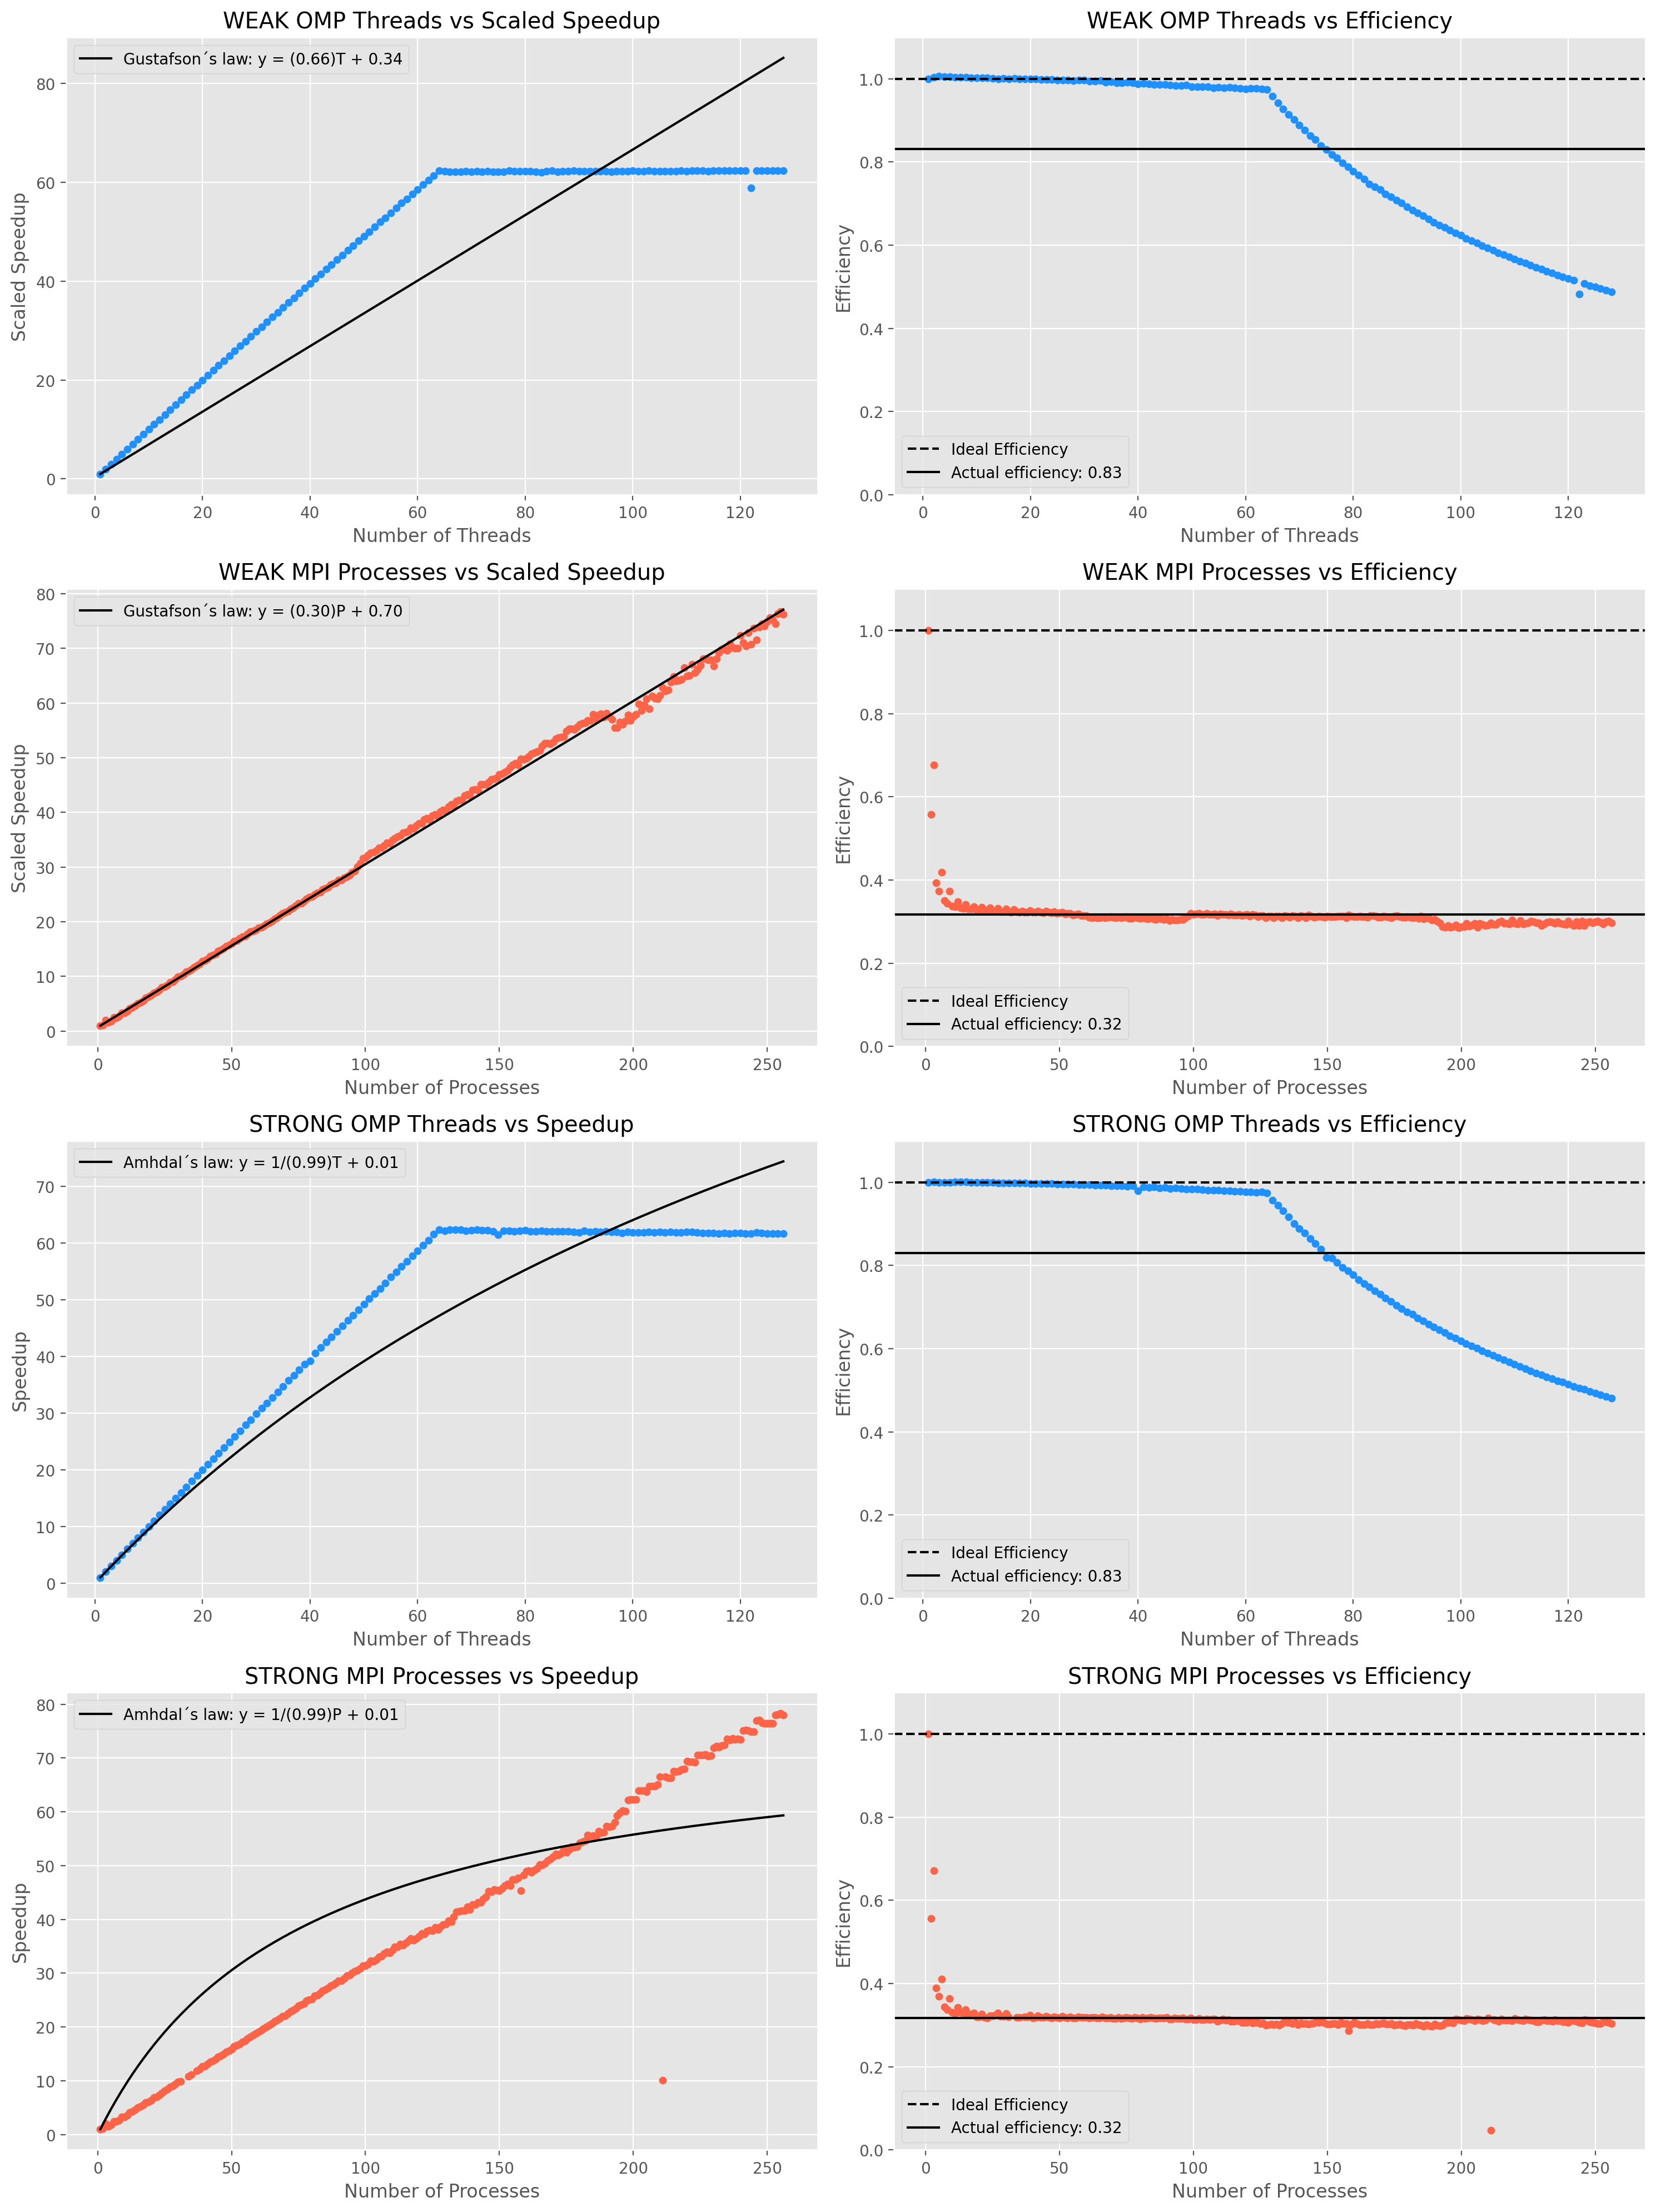

In [8]:
plt.figure(figsize=(15, 20), dpi=200)

c1='dodgerblue'
c2='tomato'

# Plot 1: Workers vs Speedup (WEAK OMP)
plt.subplot(4, 2, 1)
speedup_weak_plot(df_wo, 'WEAK',  'OMP', col=c1)

# Plot 2: Workers vs Efficiency (WEAK OMP)
plt.subplot(4, 2, 2)
efficiency_plot(df_wo, 'WEAK', 'OMP', col=c1)

# Plot 3: Workers vs Speedup (WEAK MPI)
plt.subplot(4, 2, 3)
speedup_weak_plot(df_wm, 'WEAK', 'MPI', col=c2)

# Plot 4: Workers vs Efficiency (WEAK MPI)
plt.subplot(4, 2, 4)
efficiency_plot(df_wm, 'WEAK', 'MPI', col=c2)

# Plot 5: Workers vs Speedup (STRONG OMP)
plt.subplot(4, 2, 5)
speedup_strong_plot(df_so, 'STRONG', 'OMP', col=c1)

# Plot 6: Workers vs Efficiency (STRONG OMP)
plt.subplot(4, 2, 6)
efficiency_plot(df_so, 'STRONG', 'OMP', col=c1)

# Plot 7: Workers vs Speedup (STRONG MPI)
plt.subplot(4, 2, 7)
speedup_strong_plot(df_sm, 'STRONG', 'MPI', col=c2)

# Plot 8: Workers vs Efficiency (STRONG MPI)
plt.subplot(4, 2, 8)
efficiency_plot(df_sm, 'STRONG', 'MPI', col=c2)

plt.tight_layout()
plt.savefig(f"{dir}/plots/scaling_plot.png")
plt.show()
